### Step 8: Severity Model Fit – GLM Log-Normal & Gamma

For severity modeling, we focus on estimating the **average claim amount**, conditional on a claim being **paid**.  
To ensure clean modeling, we **filter out all records where ClaimAmount == 0**, effectively removing policies with no paid claims or unresolved/unpaid reported claims.

This modeling approach targets the **distribution of actual paid claims**, aligning with typical actuarial practices in pricing.

We will fit two Generalized Linear Models (GLMs):
- **GLM with Log-Normal** assumptions using OLS on the log-transformed target.
- **GLM with Gamma** distribution and log link to capture skewness in claim amounts.

In [1]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('../data/df_freq_sev_v3.csv')

# Convert object columns to category
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype('category')

# Filter records
df_freq_sev_v3 = df[(df['AvgClaimAmount'].notna()) & (df['AvgClaimAmount'] > 0)].copy()

# Log-transform target
df_freq_sev_v3['LogClaimAmount'] = np.log(df_freq_sev_v3['ClaimAmount'])

#### Step 8.A: Initial Modelling approach

In [2]:
# Formula (same as frequency models)
formula = (
    'VehAge_log + I(VehAge_log**2) + DrivAge_cap + I(DrivAge_cap**2) + '
    'C(VehPower_bin) + Density_log + C(BonusMalus_bin) + C(Area_bin) + '
    'C(VehBrand_bin) + C(VehGas) + C(BonusMalus_bin):C(Region_bin)'
)

# Matrices
y_ln, X_ln = patsy.dmatrices('LogClaimAmount ~ ' + formula, data=df_freq_sev_v3, return_type='dataframe')
y_gamma, X_gamma = patsy.dmatrices('ClaimAmount ~ ' + formula, data=df_freq_sev_v3, return_type='dataframe')

In [3]:
# Fit log-normal model (via OLS)
ln_model = sm.OLS(y_ln, X_ln).fit()

# Predict (log scale), compute RMSE (log), and bias-correct to original €
y_pred_ln = ln_model.predict(X_ln)
residuals_ln = y_ln.values.flatten() - y_pred_ln
sigma2_ln = np.var(residuals_ln)
y_pred_ln_corrected = np.exp(y_pred_ln + 0.5 * sigma2_ln)

# RMSE in original scale
rmse_ln_euros = np.sqrt(mean_squared_error(df_freq_sev_v3['ClaimAmount'], y_pred_ln_corrected))

# Save corrected predictions
df_freq_sev_v3['y_pred_ln_corrected'] = y_pred_ln_corrected

# Rersults
print(ln_model.summary())
print('\n*** GLM Log-Normal Model Metrics ***')
print(f'AIC: {ln_model.aic:.2f}')
print(f'BIC: {ln_model.bic:.2f}')
print(f'Log-Likelihood: {ln_model.llf:.2f}')
print(f'RMSE (log-scale): {np.sqrt(mean_squared_error(y_ln, y_pred_ln)):.2f}')
print(f'Bias-corrected RMSE (in €): {rmse_ln_euros:,.2f}')

                            OLS Regression Results                            
Dep. Variable:         LogClaimAmount   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.62
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           6.23e-73
Time:                        23:01:43   Log-Likelihood:                -38409.
No. Observations:               24944   AIC:                         7.690e+04
Df Residuals:                   24903   BIC:                         7.723e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [4]:
# Fit gamma GLM with log link
gamma_model = sm.GLM(
    y_gamma,
    X_gamma,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

# Predict and evaluate
y_pred_gamma = gamma_model.predict(X_gamma)
rmse_gamma = np.sqrt(mean_squared_error(df_freq_sev_v3['ClaimAmount'], y_pred_gamma))

# Save predictions
df_freq_sev_v3['y_pred_gamma'] = y_pred_gamma

# Summary
print(gamma_model.summary())
print('\n--- GLM Gamma Model Metrics ---')
print(f'AIC: {gamma_model.aic:.2f}')
print(f'BIC: {gamma_model.bic_llf:.2f}')
print(f'Log-Likelihood: {gamma_model.llf:.2f}')
print(f'RMSE (in €): {rmse_gamma:,.2f}')


                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                24944
Model:                            GLM   Df Residuals:                    24903
Model Family:                   Gamma   Df Model:                           40
Link Function:                    Log   Scale:                          23.107
Method:                          IRLS   Log-Likelihood:            -2.5506e+05
Date:                Thu, 19 Jun 2025   Deviance:                       39516.
Time:                        23:01:45   Pearson chi2:                 5.75e+05
No. Iterations:                    57   Pseudo R-squ. (CS):           0.008345
Covariance Type:            nonrobust                                         
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [5]:
# Metrics
metrics_df = pd.DataFrame({
    'Model': ['Log-Normal (corrected)', 'Gamma (log link)'],
    'AIC': [ln_model.aic, gamma_model.aic],
    'BIC': [ln_model.bic, gamma_model.bic_llf],
    'Log-Likelihood': [ln_model.llf, gamma_model.llf],
    'RMSE (€)': [rmse_ln_euros, rmse_gamma]
})

# Comparison
print('\nModel Metrics Comparison (Severity Models)\n')
print(metrics_df.to_string(index=False, formatters={
    'AIC': '{:,.2f}'.format,
    'BIC': '{:,.2f}'.format,
    'Log-Likelihood': '{:,.2f}'.format,
    'RMSE (€)': '{:,.2f}'.format
}))


Model Metrics Comparison (Severity Models)

                 Model        AIC        BIC Log-Likelihood  RMSE (€)
Log-Normal (corrected)  76,899.62  77,232.72     -38,408.81 30,266.60
      Gamma (log link) 510,194.68 510,527.78    -255,056.34 30,202.57


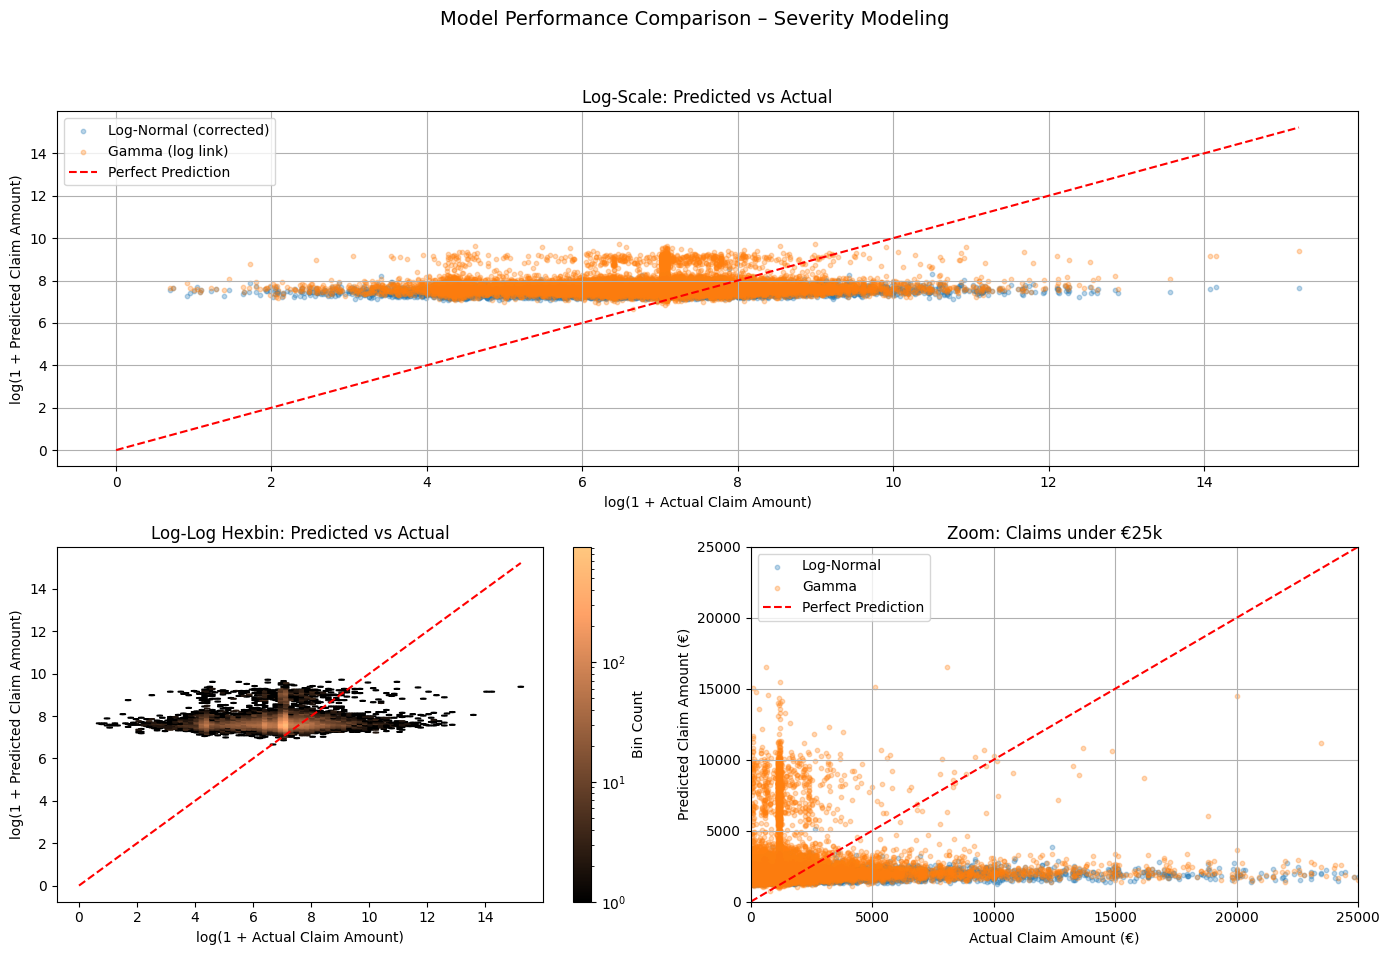

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Prep values
log1p_actual = np.log1p(df_freq_sev_v3['ClaimAmount'])
log1p_pred_ln = np.log1p(df_freq_sev_v3['y_pred_ln_corrected'])
log1p_pred_gamma = np.log1p(df_freq_sev_v3['y_pred_gamma'])

actual = df_freq_sev_v3['ClaimAmount']
pred_ln = df_freq_sev_v3['y_pred_ln_corrected']
pred_gamma = df_freq_sev_v3['y_pred_gamma']

# Start figure
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# 1. Log-Scale Scatter
ax1 = fig.add_subplot(gs[0, :])
ax1.scatter(log1p_actual, log1p_pred_ln, alpha=0.3, label='Log-Normal (corrected)', s=10)
ax1.scatter(log1p_actual, log1p_pred_gamma, alpha=0.3, label='Gamma (log link)', s=10)
ax1.plot([0, log1p_actual.max()], [0, log1p_actual.max()], 'r--', label='Perfect Prediction')
ax1.set_title('Log-Scale: Predicted vs Actual')
ax1.set_xlabel('log(1 + Actual Claim Amount)')
ax1.set_ylabel('log(1 + Predicted Claim Amount)')
ax1.grid(True)
ax1.legend()

# 2. Hexbin Plot
ax2 = fig.add_subplot(gs[1, 0])
hb = ax2.hexbin(log1p_actual, log1p_pred_gamma, gridsize=80, cmap='copper', bins='log', mincnt=1)
ax2.plot([0, log1p_actual.max()], [0, log1p_actual.max()], 'r--', label='Perfect Prediction')
ax2.set_title('Log-Log Hexbin: Predicted vs Actual')
ax2.set_xlabel('log(1 + Actual Claim Amount)')
ax2.set_ylabel('log(1 + Predicted Claim Amount)')
cb = fig.colorbar(hb, ax=ax2, label='Bin Count')

# 3. Linear Zoomed View
ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(actual, pred_ln, alpha=0.3, label='Log-Normal', s=10)
ax3.scatter(actual, pred_gamma, alpha=0.3, label='Gamma', s=10)
ax3.plot([0, 25000], [0, 25000], 'r--', label='Perfect Prediction')
ax3.set_xlim([0, 25000])
ax3.set_ylim([0, 25000])
ax3.set_title('Zoom: Claims under €25k')
ax3.set_xlabel('Actual Claim Amount (€)')
ax3.set_ylabel('Predicted Claim Amount (€)')
ax3.grid(True)
ax3.legend()

# Layout adjustments
plt.suptitle('Model Performance Comparison – Severity Modeling', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Step 8.A Summary: Initial Severity Modeling (*ClaimAmount*)

We modeled average claim severity using two statistical techniques:

- **Log-Normal GLM**: Modeled via Ordinary Least Squares (OLS) on log-transformed *ClaimAmount*, then **bias-corrected using an exponential adjustment** (*exp(ŷ + 0.5σ²)*) to recover the expected value on the original euro scale.  
    This correction is necessary because the mean of a log-normal distribution is not simply the exponentiated log-mean; omitting this leads to systematic underestimation.

- **Gamma GLM** with log link: Modeled directly on the original *ClaimAmount* values using a log link to handle **positive, right-skewed distributions** often seen in insurance claims.

To ensure full compatibility with the **main frequency modeling approach** (Poisson GLM, Negative Binomial, Discrete NB), we applied **the exact same feature formula** in severity modeling.  
This consistent structure supports:

- aligned interpretation of coefficients,
- unified deployment logic, and
- transparent derivation of the **pure premium** (as: frequency × severity).

The formula includes:

- **Continuous predictors**: *VehAge_log*, *I(VehAge_log²)*, *DrivAge_cap*, *I(DrivAge_cap²)*, *Density_log*
- **Categorical predictors**: *VehPower_bin*, *VehGas*, *VehBrand_bin*, *BonusMalus_bin*, *Area_bin*, and the interaction term *BonusMalus_bin * Region_bin*

--

##### Model Comparison Table

- RMSE values are **nearly identical**, indicating that **both models predict average claim size with similar numerical precision** on the in-sample data.
- However, the **Log-Normal model has drastically lower AIC and BIC**, which reflect a **much better model fit relative to its complexity**.
- This stark contrast arises because:
  - the Gamma model operates on raw € values, which are **highly skewed and heteroscedastic** (variance increases with mean),
  - and the Gamma distribution struggles more with extreme claims and convergence,
  - while the log-transformation in the Log-Normal model **stabilizes variance**, handles skewness more naturally, and facilitates tractable modeling.

--

##### Model Evaluation Visualizations

1. **Log-Scale Scatter Plot**: *log(1 + Predicted)* vs *log(1 + Actual)*  
   Helps evaluate relative prediction quality across the entire claim range while reducing distortion from large outliers.  
   **Log-Normal predictions are more symmetrically distributed** around the ideal 45° line.

2. **Log-Log Hexbin Plot** (focused on **Gamma** predictions):  
   Provides a **density-aware view** of prediction accuracy in the core zone (~€1k–€10k), where most claims cluster.  
   The Gamma model shows **wider scatter and less concentration**, suggesting reduced stability in this dense area.  
   This diagnostic plot is focused on Gamma because **Log-Normal already showed good structure in the regular scatterplot**, requiring no additional densification.

3. **Zoomed Linear Scatter Plot**: Claims < €25,000  
   Focuses on the **99.5% most frequent claims**, where pricing decisions are most sensitive.  
   **Log-Normal is more centered and stable**, while **Gamma tends to overestimate mid-range values**, particularly in the €5,000–€15,000 band.

--

##### Recommendation

Although both models offer comparable in-sample RMSE, we **recommend using the Log-Normal model for severity prediction**, because:

- It yields a **superior likelihood fit** (AIC/BIC), meaning it's statistically more likely to generalize well.
- It **naturally accommodates claim skewness** via log transformation, avoiding instability in tail predictions.
- It produces **tighter, more interpretable predictions** for the range of claims most relevant for business and pricing (~€0–€25k).
- It aligns closely with business logic, actuarial intuition, and reproducibility; making it **well-suited for use in a frequency × severity pricing framework**.

For these reasons, **Log-Normal GLM (with bias correction) is the preferred severity model** in our pure premium modeling pipeline.

---

#### Step 8.B: Train-Test Validation and Model Performance

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.formula.api as smf
import numpy as np

# Split into train/test (only nonzero ClaimAmount were kept already)
df_train, df_test = train_test_split(df_freq_sev_v3, test_size=0.2, random_state=42)

# Fit model on log-ClaimAmount
model_ln = smf.ols('LogClaimAmount ~ ' + formula, data=df_train).fit()

# Predict with bias correction
sigma2 = model_ln.mse_resid
df_test['sev_pred'] = np.exp(model_ln.predict(df_test) + sigma2 / 2)

# Evaluate performance
mse = mean_squared_error(df_test['ClaimAmount'], df_test['sev_pred'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test['ClaimAmount'], df_test['sev_pred'])

print("*** Severity Model Validation ***")
print(f"RMSE: {rmse:.2f} €")
print(f"MAE: {mae:.2f} €")
print(f"Mean actual: {df_test['ClaimAmount'].mean():.2f} €")
print(f"Mean predicted: {df_test['sev_pred'].mean():.2f} €")

*** Severity Model Validation ***
RMSE: 21229.14 €
MAE: 1955.40 €
Mean actual: 2269.79 €
Mean predicted: 1897.28 €


#### Step 8.B Summary: Severity Model Validation – Train/Test Split (Log-Normal Model)

We validated the selected **Log-Normal model** using a train/test split (80/20) on all records with positive claim amounts. The model was fitted using OLS on the log-transformed target `LogClaimAmount`, and predictions were retransformed with bias correction using the residual variance (σ²).

- The model performs well overall, with a **modest absolute error** (MAE) in the €2,000 range, which is reasonable given the typical scale and variance in motor claim amounts.
- The RMSE reflects a few large claims that increase dispersion, which is **common in severity modeling**.
- The **mean prediction is close to the actual mean**, suggesting the model captures the general portfolio trend despite some variance at the tail.

##### Conclusion:
The **Log-Normal model** is validated as a reliable estimator of claim severity. It balances interpretability and performance, and is consistent with the GLM framework used in the frequency model. This validated output can now be combined with predicted frequency to compute the **pure premium**.

---

#### Step 8.C: Refit Log-Normal on full dataset

In [8]:
import statsmodels.formula.api as smf
import numpy as np

# Fit model on non-zero claims (df_freq_sev_v3)
model_ln_full = smf.ols('LogClaimAmount ~ ' + formula, data=df_freq_sev_v3).fit()
sigma2_full = model_ln_full.mse_resid

# Ensure df (full dataset) has LogClaimAmount column for masking
df['LogClaimAmount'] = np.where(
    (df['AvgClaimAmount'].notna()) & (df['AvgClaimAmount'] > 0),
    np.log(df['ClaimAmount']),
    np.nan
)

# Predict on full dataset with bias correction
df['sev_pred'] = np.where(
    df['LogClaimAmount'].notna(),
    np.exp(model_ln_full.predict(df) + sigma2_full / 2),
    0.0
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Step 8.D: Final Model Coefficients – GLM Log-Normal

Below are the estimated coefficients from the severity model. These represent the *log-effect* on the average claim amount for policies with non-zero claims.

In [9]:
import pandas as pd

# Coefficients
coeffs_ln = model_ln_full.params.sort_values()
coeffs_ln = coeffs_ln.reset_index()
coeffs_ln.columns = ['Variable', 'Coefficient']

# Display
pd.set_option('display.max_rows', 100)
coeffs_ln

,Variable,Coefficient
0,C(BonusMalus_bin)[Extreme_140plus]:C(Region_bi...,-0.456054
1,C(BonusMalus_bin)[T.Safe_50_55],-0.290101
2,C(Area_bin)[T.Group_Low_Risk],-0.134899
3,C(BonusMalus_bin)[High_100_140]:C(Region_bin)[...,-0.129408
4,C(BonusMalus_bin)[T.Standard_60_75],-0.084884
5,C(BonusMalus_bin)[Standard_60_75]:C(Region_bin...,-0.031805
6,C(VehBrand_bin)[T.Group_Unstable],-0.028036
7,C(VehBrand_bin)[T.Group_StableLow],-0.026949
8,C(VehGas)[T.Regular],-0.026775
9,VehAge_log,-0.019109


#### Step 8.D Summary: Interpretation of Severity Model Coefficients (GLM Log-Normal)

We now analyze the coefficients obtained from the final GLM Log-Normal model fitted on the full dataset (non-zero claims). These coefficients express the **log-relative change in average claim severity** compared to a reference category (i.e., the most frequent or baseline class per variable).

--

##### Key Insights

- **Intercept**: Represents the baseline log-claim amount for a policyholder in all reference categories.
- **VehAge_log**: Has a **negative coefficient** (−0.0237), meaning **older vehicles tend to be associated with slightly lower claim severity**.
- **DrivAge_cap**: Slight **positive effect**, suggesting that **older drivers may incur marginally higher claim amounts**.
- **Density_log**: Very small **negative effect**, indicating that **urbanization is not strongly correlated with severity** in this model.

--

##### Notable Categorical Effects

- `BonusMalus_bin`:
  - **Safe_50** and **Standard_55_75** show **negative coefficients**, confirming that **drivers with low risk history not only claim less often but also claim lower amounts**.
  - **Extreme_150plus** shows a **very small negative or near-zero effect**, implying that high Bonus-Malus may increase frequency, but **does not necessarily translate to higher severity**.

- `VehPower_bin`:
  - **Group_LowVol_Mixed** and **Group_Risky** show **positive effects**, indicating **some correlation between vehicle power (and riskiness) and average claim size**.

- `VehBrand_bin`:
  - **Group_RiskyCore** (e.g., brand B2) shows a **positive effect**, reflecting its **known high severity pattern**.
  - **Group_Standard** and **Group_OtherSafe** show more **stable or negative coefficients**, confirming **lower average claim costs**.

- `Area_bin`:
  - **Group_Standard** and **Group_Low_Risk** areas show **neutral to mildly negative effects**, reinforcing that **location has a limited impact on severity** compared to frequency.

--

##### Interaction Effects

The model incorporates interactions between *BonusMalus_bin* and *Region_bin*, revealing nuances in how historical driving behavior affects claim amounts across geographies:

- Some combinations involving **Extreme BonusMalus** with *Group_High_Risk* regions show **positive severity effects**, suggesting **concentration of both high frequency and severity in some segments**.
- Conversely, many interactions with *Safe_50* or *Standard_55_75* are **neutral or even negative**, reinforcing the **stability of low-risk drivers regardless of region**.

--

##### Practical Interpretation Example

Imagine a policyholder with these traits:

- **BonusMalus = 50** → Grouped under *Safe_50*
- **Vehicle Power = 9** → Categorized as *Group_Risky*
- **Brand = B2** → Known for high severity, falls into *Group_RiskyCore*
- **Area = B** → Mapped to *Group_High_Risk*
- **Region = R24** → Tagged as *Group_High_Risk*

This profile combines **vehicle power and brand associated with higher-than-average claim amounts**, **a high-risk area**, and **a historically low-risk driver (Safe_50)**. While **frequency may be low due to the BonusMalus**, the **expected severity per claim is relatively high** due to the other characteristics; a useful pattern for **layered pricing strategies**.

--

This interpretation translates the severity model outputs into **practical segmentation logic**, aiding tariff calibration and refined underwriting actions.

---

In [10]:
df.to_csv('../data/df_freq_sev_v3.csv', index=False)